In [1]:
import os
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches, colors
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
import numpy.ma as ma
import pandas as pd
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy.mask as em

In [2]:
sns.set_style('white')
sns.set(font_scale=1.5)


In [3]:
data = et.data.get_data('cold-springs-fire')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

In [4]:
landsat_paths_pre_path = os.path.join("data", "cold-springs-fire", "landsat_collect", 
                                      "LC080340322016070701T1-SC20180214145604", "crop", 
                                      "*band*.tif")

landsat_paths_pre = glob(landsat_paths_pre_path)
landsat_paths_pre.sort()

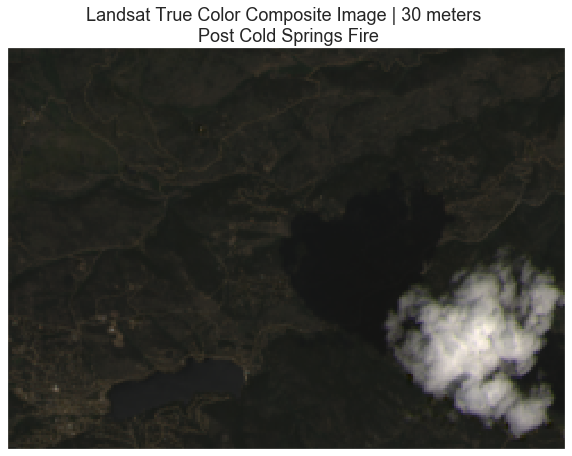

In [5]:
landsat_pre_st_path = os.path.join("data", "cold-springs-fire", 
                                   "outputs", "landsat_pre_st.tif")

es.stack(landsat_paths_pre, landsat_pre_st_path)
with rio.open(landsat_pre_st_path) as landsat_pre_src:
    landsat_pre = landsat_pre_src.read(masked=True)
    landsat_extent = plotting_extent(landsat_pre_src)
    
ep.plot_rgb(landsat_pre,
            rgb=[3, 2, 1],
            extent=landsat_extent,
            title="Landsat True Color Composite Image | 30 meters \n Post Cold Springs Fire")

plt.show()

In [6]:
landsat_pre_cl_path = os.path.join("data", "cold-springs-fire", "landsat_collect", 
                                   "LC080340322016070701T1-SC20180214145604", "crop", 
                                   "LC08_L1TP_034032_20160707_20170221_01_T1_pixel_qa_crop.tif")

In [7]:
with rio.open(landsat_pre_cl_path) as landsat_pre_cl:
    landsat_qa = landsat_pre_cl.read(1)
    landsat_ext = plotting_extent(landsat_pre_cl)

In [8]:
cmap = plt.cm.get_cmap('tab20b', 11)

In [9]:
vals = np.unique(landsat_qa).tolist()
bins = [0] + vals

In [10]:
bounds = [((a + b) / 2) for a, b in zip(bins[:-1], bins[1::1])] + \
    [(bins[-1] - bins[-2]) + bins[-1]]
norm = colors.BoundaryNorm(bounds, cmap.N)

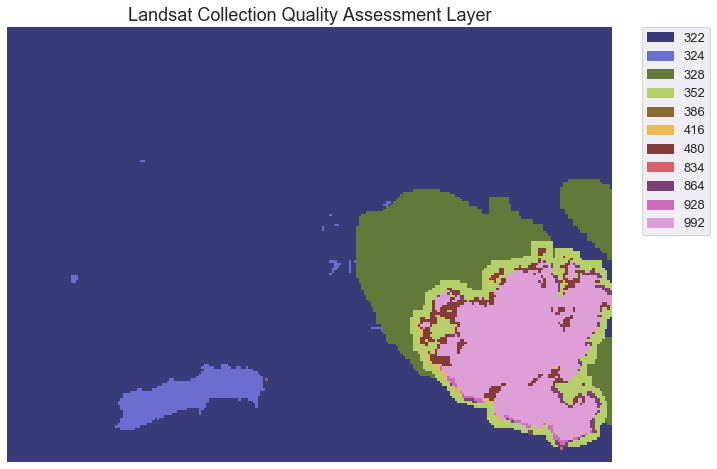

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))

im = ax.imshow(landsat_qa,
               cmap=cmap,
               norm=norm)

ep.draw_legend(im,
               classes=vals,
               cmap=cmap, titles=vals)

ax.set_title("Landsat Collection Quality Assessment Layer")
ax.set_axis_off()
plt.show()


In [12]:
high_cloud_confidence = em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"]
cloud = em.pixel_flags["pixel_qa"]["L8"]["Cloud"]
cloud_shadow = em.pixel_flags["pixel_qa"]["L8"]["Cloud Shadow"]

all_masked_values = cloud_shadow + cloud + high_cloud_confidence
all_masked_values

[328,
 392,
 840,
 904,
 1350,
 352,
 368,
 416,
 432,
 480,
 864,
 880,
 928,
 944,
 992,
 480,
 992]

In [13]:
cl_mask = em._create_mask(landsat_qa, all_masked_values)
np.unique(cl_mask)

array([0, 1], dtype=int16)

In [14]:
landsat_pre_cl_free = em.mask_pixels(landsat_pre, cl_mask)

In [15]:
landsat_pre_cl_free = em.mask_pixels(
    landsat_pre, landsat_qa, vals=all_masked_values)

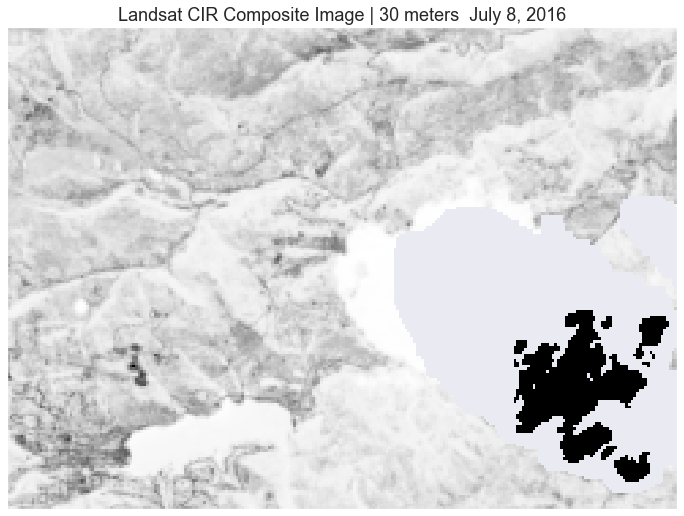

In [16]:
ep.plot_bands(landsat_pre_cl_free[6],
              extent=landsat_extent,
              cmap="Greys",
              title="Landsat CIR Composite Image | 30 meters  July 8, 2016",
              cbar=False)
plt.show()

In [17]:
sns.set_style('white')
sns.set(font_scale=1.5)

In [18]:
data = et.data.get_data('cold-springs-fire')
data_2 = et.data.get_data('cs-test-landsat')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))


In [19]:
landsat_paths_pre_path = os.path.join("data", "cold-springs-fire", "landsat_collect", 
                                      "LC080340322016070701T1-SC20180214145604", "crop", 
                                      "*band*.tif")

landsat_paths_pre = glob(landsat_paths_pre_path)
landsat_paths_pre.sort()

landsat_pre_cloud, landsat_pre_meta = es.stack(
    landsat_paths_pre, nodata=-9999)

landsat_pre_cloud_ext_bds = rio.transform.array_bounds(
    landsat_pre_cloud.shape[1],
    landsat_pre_cloud.shape[2],
    landsat_pre_meta["transform"])

landsat_pre_cl_path = os.path.join("data", "cold-springs-fire", "landsat_collect", 
                                   "LC080340322016070701T1-SC20180214145604", "crop", 
                                   "LC08_L1TP_034032_20160707_20170221_01_T1_pixel_qa_crop.tif")

with rio.open(landsat_pre_cl_path) as landsat_pre_cl:
    landsat_qa = landsat_pre_cl.read(1)
    
cloud_shadow = [328, 392, 840, 904, 1350]
cloud = [352, 368, 416, 432, 480, 864, 880, 928, 944, 992]
high_confidence_cloud = [480, 992]

vals_to_mask = cloud_shadow + cloud + high_confidence_cloud

landsat_pre_cloud_masked = em.mask_pixels(landsat_pre_cloud, landsat_qa,
                                          vals=vals_to_mask)

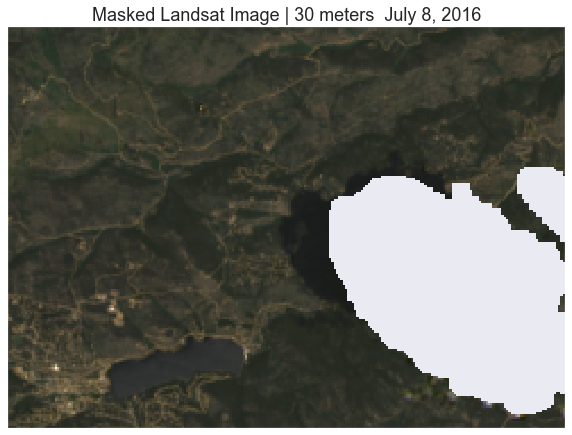

In [20]:
ep.plot_rgb(landsat_pre_cloud_masked,
            rgb=[3, 2, 1],
            title="Masked Landsat Image | 30 meters  July 8, 2016")
plt.show()

In [21]:
landsat_paths_pre_cloud_free = glob(
    os.path.join("data", "cs-test-landsat", "*band*.tif"))

landsat_paths_pre_cloud_free.sort()

In [22]:
landsat_pre_cloud_free, landsat_pre_cloud_free_meta = es.stack(
    landsat_paths_pre_cloud_free,
    nodata=-9999)

In [23]:
landsat_no_clouds_bds = rio.transform.array_bounds(
    landsat_pre_cloud_free.shape[1],
    landsat_pre_cloud_free.shape[2],
    landsat_pre_cloud_free_meta["transform"])

In [24]:
landsat_no_clouds_bds == landsat_pre_cloud_ext_bds

False

In [25]:
import box

In [26]:
from box import Box

In [27]:
from shapely.geometry import mapping, box


In [28]:
cloud_free_scene_bds = box(*landsat_no_clouds_bds)
cloudy_scene_bds = box(*landsat_pre_cloud_ext_bds)

In [29]:
cloud_free_scene_bds.intersects(cloudy_scene_bds)

True

In [30]:
landsat_pre_meta["crs"] == landsat_pre_cloud_free_meta["crs"]
landsat_pre_cloud.shape == landsat_pre_cloud_free.shape

False

In [31]:
landsat_clouds_clip = es.extent_to_json(list(landsat_pre_cloud_ext_bds))

In [32]:
landsat_cloud_free_out_path = os.path.join("data", "outputs", "cloud_mask")

if not os.path.exists(landsat_cloud_free_out_path):
    os.makedirs(landsat_cloud_free_out_path)

cropped_cloud_list = es.crop_all(landsat_paths_pre_cloud_free, 
                                 landsat_cloud_free_out_path, 
                                 [landsat_clouds_clip], overwrite=True)

landsat_pre_cloud_free, landsat_pre_clod_free_meta = es.stack(
    cropped_cloud_list)
landsat_pre_cloud_free.shape, landsat_pre_cloud_masked.shape

((7, 177, 246), (7, 177, 246))

In [33]:
mask = landsat_pre_cloud_masked.mask

landsat_pre_cloud_masked_copy = np.copy(landsat_pre_cloud_masked)

landsat_pre_cloud_masked_copy[mask] = landsat_pre_cloud_free[mask]

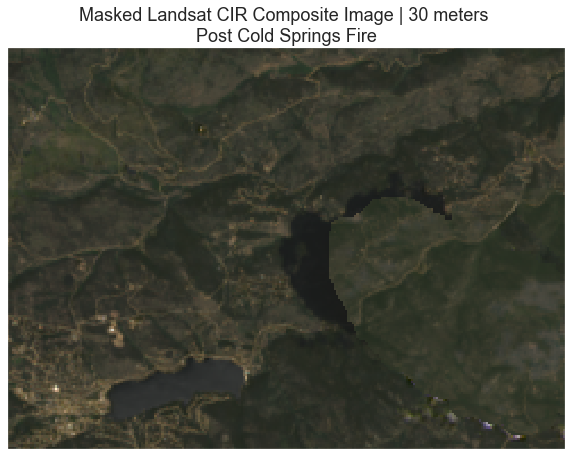

In [34]:
ep.plot_rgb(landsat_pre_cloud_masked_copy,
            rgb=[3, 2, 1],
            title="Masked Landsat CIR Composite Image | 30 meters \n Post Cold Springs Fire ")
plt.show()

In [35]:
landsat_paths_pre_path = os.path.join("data", "cold-springs-fire", "landsat_collect", 
                                      "LC080340322016072301T1-SC20180214145802", "crop", 
                                      "*band*.tif")

In [36]:
landsat_paths_pre = glob(landsat_paths_pre_path)
landsat_paths_pre.sort()

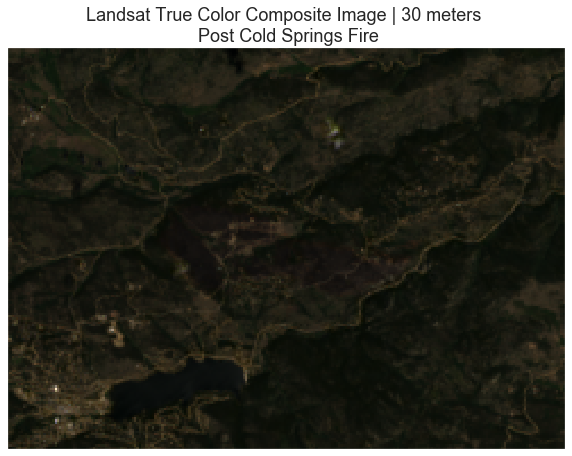

In [37]:
landsat_pre_st_path = os.path.join("data", "cold-springs-fire", 
                                   "outputs", "landsat_pre_st.tif")

es.stack(landsat_paths_pre, landsat_pre_st_path)
with rio.open(landsat_pre_st_path) as landsat_pre_src:
    landsat_pre = landsat_pre_src.read(masked=True)
    landsat_extent = plotting_extent(landsat_pre_src)
    
ep.plot_rgb(landsat_pre,
            rgb=[3, 2, 1],
            extent=landsat_extent,
            title="Landsat True Color Composite Image | 30 meters \n Post Cold Springs Fire")

plt.show()

In [38]:
landsat_pre_cl_path = os.path.join("data", "cold-springs-fire", "landsat_collect", 
                                   "LC080340322016072301T1-SC20180214145802", "crop", 
                                   "LC08_L1TP_034032_20160723_20180131_01_T1_pixel_qa_crop.tif")
with rio.open(landsat_pre_cl_path) as landsat_pre_cl:
    landsat_qa = landsat_pre_cl.read(1)
    landsat_ext = plotting_extent(landsat_pre_cl)

In [39]:
cmap = plt.cm.get_cmap('tab20b', 11)
vals = np.unique(landsat_qa).tolist()
bins = [0] + vals

In [40]:
bounds = [((a + b) / 2) for a, b in zip(bins[:-1], bins[1::1])] + \
    [(bins[-1] - bins[-2]) + bins[-1]]
norm = colors.BoundaryNorm(bounds, cmap.N)

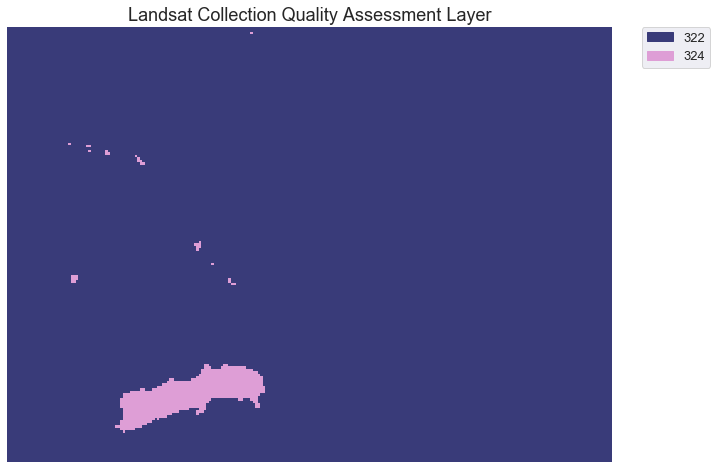

In [41]:
fig, ax = plt.subplots(figsize=(12, 8))

im = ax.imshow(landsat_qa,
               cmap=cmap,
               norm=norm)

ep.draw_legend(im,
               classes=vals,
               cmap=cmap, titles=vals)

ax.set_title("Landsat Collection Quality Assessment Layer")
ax.set_axis_off()
plt.show()

In [42]:
high_cloud_confidence = em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"]
cloud = em.pixel_flags["pixel_qa"]["L8"]["Cloud"]
cloud_shadow = em.pixel_flags["pixel_qa"]["L8"]["Cloud Shadow"]

all_masked_values = cloud_shadow + cloud + high_cloud_confidence

In [43]:
cl_mask = em._create_mask(landsat_qa, all_masked_values)
np.unique(cl_mask)
landsat_pre_cl_free = em.mask_pixels(landsat_pre, cl_mask)
landsat_pre_cl_free = em.mask_pixels(landsat_pre, landsat_qa, vals=all_masked_values)
ep.plot_bands(landsat_pre_cl_free[6],
              extent=landsat_extent,
              cmap="Greys",
              title="Landsat CIR Composite Image | 30 meters  July 8, 2016",
              cbar=False)
plt.show()

ValueError: The values provided for the mask do not occur in your mask array.